# Low-Dimensional Representation Using Autoencoder

## Getting the Data

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
from herdingspikes.hs2 import HSDetection
from herdingspikes.probe import HierlmannVisapyEmulationProbe
import matplotlib.pyplot as plt
import h5py
import numpy as np

np.random.seed(0)

In [2]:
import urllib
file_url = 'https://datasync.ed.ac.uk/public.php/webdav'

password_mgr = urllib.request.HTTPPasswordMgrWithDefaultRealm()
password_mgr.add_password(None, file_url, "GbnXJ5bU3m9JPau", "HS2")
handler = urllib.request.HTTPBasicAuthHandler(password_mgr)
opener = urllib.request.build_opener(handler)
opener.open(file_url)
urllib.request.install_opener(opener)
with urllib.request.urlopen(file_url) as response, open('visapy_data.npy', 'wb') as out_file:
    data = response.read()
    out_file.write(data)

# raw data location
data_path = 'visapy_data.npy'

In [3]:
# detection parameters
to_localize = False
cutout_start = 14
cutout_end = 36
threshold = 24
file_directory = 'results/'
file_name = 'ProcessedSpikes_visapy'

In [4]:
Probe = HierlmannVisapyEmulationProbe('visapy_data.npy')
H = HSDetection(Probe, to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name, 
                file_directory_name=file_directory, save_all=True)

File size: 122400102
Number of channels: 102


## Detecting Spikes

In [5]:
H.DetectFromRaw()

# Sampling rate: 32000
# Localization Off
# Not Masking any Channels
# Writing out extended detection info
# Number of recorded channels: 102
# Analysing frames: 1200001, Seconds:37.50003125
# Frames before spike in cutout: 32
# Frames after spike in cutout: 70
# tcuts: 44 59
# tInc: 50000
# Analysing 50000 frames; from -44 to 50059
# Analysing 50000 frames; from 49956 to 100059
# Analysing 50000 frames; from 99956 to 150059
# Analysing 50000 frames; from 149956 to 200059
# Analysing 50000 frames; from 199956 to 250059
# Analysing 50000 frames; from 249956 to 300059
# Analysing 50000 frames; from 299956 to 350059
# Analysing 50000 frames; from 349956 to 400059
# Analysing 50000 frames; from 399956 to 450059
# Analysing 50000 frames; from 449956 to 500059
# Analysing 50000 frames; from 499956 to 550059
# Analysing 50000 frames; from 549956 to 600059
# Analysing 50000 frames; from 599956 to 650059
# Analysing 50000 frames; from 649956 to 700059
# Analysing 50000 frames; from 699956 to 75

In [6]:
H.LoadDetected()

Detected and read 19341 spikes.


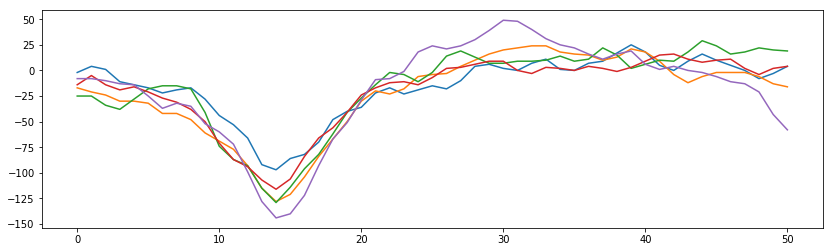

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(14,4))
for i in [14, 18, 77, 90, 156]:
    plt.plot(H.spikes['Shape'][i])
plt.show()
    

In [8]:
length = H.spikes['Shape'][0].shape[0]
total_sigs = H.spikes['Shape'].shape[0]
embedding_size = (int)(length//4)

electrode_data = np.zeros([total_sigs, length])
list_of_sigs = np.random.choice(total_sigs, total_sigs, replace=False)

for i in list_of_sigs:
    electrode_data[i, :] = H.spikes['Shape'][i]
print(electrode_data.shape)

(19341, 51)


## Scaling data between 0 and 1

In [9]:
# electrode_data = electrode_data_temp[:, :]

In [10]:
# max_val = np.amax(electrode_data)
# min_val = np.amin(electrode_data)
# span = max_val - min_val
# electrode_data = (electrode_data - min_val)/span

In [11]:
print(electrode_data)

[[ -7.  -2.   4. ...   7.   7.   9.]
 [ 35.  33.  26. ...   0.  -7. -10.]
 [ 15.  16.   8. ... -11.  -1.   1.]
 ...
 [ -2. -19. -23. ...  -7. -15. -31.]
 [ 12.   0.  -3. ...  -8. -10.  -5.]
 [-20. -32. -29. ...   9.   0.  -9.]]


## Designing the AutoEncoder 

In [12]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data

torch.cuda.set_device(0)
torch.manual_seed(0)

In [13]:
class autoencoder(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(autoencoder, self).__init__()
        activation_layer = nn.PReLU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 100),
                                     activation_layer,
                                     nn.Linear(100, 50),
                                     activation_layer,
                                     nn.Linear(50, 25),
                                     activation_layer,
                                     nn.Linear(25, 80),
                                     activation_layer,
                                     nn.Linear(80, 28),
                                     activation_layer,
                                     nn.Linear(28, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 16),
                                     activation_layer,
                                     nn.Linear(16, 25),
                                     activation_layer,
                                     nn.Linear(25, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

## Splitting the data into Train and Test

In [14]:
train_lim = int(0.8*electrode_data.shape[0])
electrode_data_train = electrode_data[:train_lim, :]
electrode_data_test = electrode_data[train_lim:, :]

print("Training Datasize:", electrode_data_train.shape)
print("Test Datasize:", electrode_data_test.shape)

Training Datasize: (15472, 51)
Test Datasize: (3869, 51)


In [15]:
import random
random.seed(0)

def train_ae(model, input_data, criterion, optimizer, epoch_range,  batch_size):
    losses = []
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, input_data.shape[0]), batch_size)
        for feats in selected:
            x = input_data[feats, :]
            x = torch.from_numpy(x).float().cuda()
            #---------FORWARD------------#
            enc, out = model.forward(x)
            out = torch.tensor(out).float().cuda()
            loss = criterion(out, x)
            #---------BACKWARD------------#
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(loss.data[0])
        print('epoch [{}/{}], loss:{:.5f}, avg:{:.5f}'.format(num_epoch + 1, epoch_range, 
                                                              loss.data[0], sum(losses[-10:])/len(losses[-10:])))
    return enc, out, losses

In [16]:
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)

In [17]:
epoch_range = 5000
batch_size = 150
learning_rate = 0.0001

ae_1 = autoencoder(length, embedding_size).cuda()
ae_1.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_1.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses = train_ae(ae_1, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

epoch [1/5000], loss:2696.60938, avg:2696.60938
epoch [2/5000], loss:814.14386, avg:1755.37659
epoch [3/5000], loss:359.83264, avg:1290.19531
epoch [4/5000], loss:91.81929, avg:990.60132
epoch [5/5000], loss:119.90456, avg:816.46198
epoch [6/5000], loss:70.90757, avg:692.20288
epoch [7/5000], loss:376.38910, avg:647.08667
epoch [8/5000], loss:156.40436, avg:585.75134
epoch [9/5000], loss:302.80026, avg:554.31232
epoch [10/5000], loss:583.59979, avg:557.24109
epoch [11/5000], loss:55.95045, avg:293.17520
epoch [12/5000], loss:181.54216, avg:229.91504
epoch [13/5000], loss:73.21373, avg:201.25313
epoch [14/5000], loss:47.89215, avg:196.86040
epoch [15/5000], loss:373.94431, avg:222.26439
epoch [16/5000], loss:247.13025, avg:239.88667
epoch [17/5000], loss:89.82492, avg:211.23022
epoch [18/5000], loss:351.12759, avg:230.70256
epoch [19/5000], loss:69.86075, avg:207.40862
epoch [20/5000], loss:81.79202, avg:157.22783
epoch [21/5000], loss:335.43103, avg:185.17589
epoch [22/5000], loss:49.9

epoch [180/5000], loss:30.37217, avg:40.77320
epoch [181/5000], loss:27.64705, avg:41.26963
epoch [182/5000], loss:51.22570, avg:41.50315
epoch [183/5000], loss:54.36275, avg:42.64886
epoch [184/5000], loss:35.15639, avg:40.00033
epoch [185/5000], loss:70.78148, avg:43.49968
epoch [186/5000], loss:155.31964, avg:55.47728
epoch [187/5000], loss:48.24220, avg:56.88478
epoch [188/5000], loss:33.99423, avg:54.18436
epoch [189/5000], loss:60.94137, avg:56.80430
epoch [190/5000], loss:37.26187, avg:57.49327
epoch [191/5000], loss:70.54962, avg:61.78353
epoch [192/5000], loss:38.03685, avg:60.46465
epoch [193/5000], loss:53.05456, avg:60.33383
epoch [194/5000], loss:30.18585, avg:59.83677
epoch [195/5000], loss:48.61544, avg:57.62016
epoch [196/5000], loss:45.59544, avg:46.64775
epoch [197/5000], loss:82.78248, avg:50.10177
epoch [198/5000], loss:53.47141, avg:52.04949
epoch [199/5000], loss:62.21800, avg:52.17715
epoch [200/5000], loss:75.98025, avg:56.04899
epoch [201/5000], loss:53.25534, 

epoch [359/5000], loss:43.50528, avg:34.06677
epoch [360/5000], loss:27.40664, avg:34.43447
epoch [361/5000], loss:31.90886, avg:35.14094
epoch [362/5000], loss:34.23763, avg:35.34898
epoch [363/5000], loss:26.34055, avg:34.17495
epoch [364/5000], loss:28.82308, avg:31.15774
epoch [365/5000], loss:34.24591, avg:31.92059
epoch [366/5000], loss:44.48229, avg:32.50608
epoch [367/5000], loss:85.20782, avg:38.65677
epoch [368/5000], loss:22.27472, avg:37.84328
epoch [369/5000], loss:49.39753, avg:38.43250
epoch [370/5000], loss:21.99598, avg:37.89143
epoch [371/5000], loss:21.69054, avg:36.86960
epoch [372/5000], loss:42.21710, avg:37.66755
epoch [373/5000], loss:25.42008, avg:37.57550
epoch [374/5000], loss:39.23081, avg:38.61628
epoch [375/5000], loss:48.33466, avg:40.02515
epoch [376/5000], loss:39.52853, avg:39.52978
epoch [377/5000], loss:39.37114, avg:34.94611
epoch [378/5000], loss:74.69743, avg:40.18838
epoch [379/5000], loss:50.08171, avg:40.25680
epoch [380/5000], loss:27.32032, a

epoch [538/5000], loss:30.51283, avg:34.61929
epoch [539/5000], loss:26.73801, avg:34.57855
epoch [540/5000], loss:40.52413, avg:34.67517
epoch [541/5000], loss:52.94738, avg:36.18084
epoch [542/5000], loss:51.31412, avg:38.98721
epoch [543/5000], loss:58.75481, avg:42.73457
epoch [544/5000], loss:37.47222, avg:39.20555
epoch [545/5000], loss:31.81076, avg:39.19935
epoch [546/5000], loss:29.49980, avg:40.29004
epoch [547/5000], loss:31.72086, avg:39.12949
epoch [548/5000], loss:52.02752, avg:41.28096
epoch [549/5000], loss:43.37822, avg:42.94498
epoch [550/5000], loss:62.95803, avg:45.18837
epoch [551/5000], loss:53.16006, avg:45.20964
epoch [552/5000], loss:90.83398, avg:49.16163
epoch [553/5000], loss:35.84064, avg:46.87021
epoch [554/5000], loss:52.29148, avg:48.35213
epoch [555/5000], loss:40.01760, avg:49.17282
epoch [556/5000], loss:43.78710, avg:50.60155
epoch [557/5000], loss:49.85608, avg:52.41508
epoch [558/5000], loss:41.09628, avg:51.32195
epoch [559/5000], loss:87.17284, a

epoch [717/5000], loss:23.71117, avg:43.55882
epoch [718/5000], loss:26.24952, avg:42.48815
epoch [719/5000], loss:19.29515, avg:36.54552
epoch [720/5000], loss:15.49203, avg:34.19830
epoch [721/5000], loss:32.41243, avg:35.04182
epoch [722/5000], loss:25.19002, avg:33.93089
epoch [723/5000], loss:41.96333, avg:30.07471
epoch [724/5000], loss:41.23629, avg:29.09312
epoch [725/5000], loss:20.15888, avg:28.23500
epoch [726/5000], loss:30.85926, avg:27.65681
epoch [727/5000], loss:33.72813, avg:28.65850
epoch [728/5000], loss:39.81716, avg:30.01526
epoch [729/5000], loss:53.39326, avg:33.42508
epoch [730/5000], loss:37.87633, avg:35.66351
epoch [731/5000], loss:27.61314, avg:35.18358
epoch [732/5000], loss:45.77225, avg:37.24181
epoch [733/5000], loss:17.70071, avg:34.81554
epoch [734/5000], loss:31.46008, avg:33.83792
epoch [735/5000], loss:33.52443, avg:35.17448
epoch [736/5000], loss:38.56190, avg:35.94474
epoch [737/5000], loss:46.84148, avg:37.25607
epoch [738/5000], loss:11.25904, a

epoch [896/5000], loss:24.73779, avg:35.86804
epoch [897/5000], loss:17.48289, avg:33.37187
epoch [898/5000], loss:28.23438, avg:32.81414
epoch [899/5000], loss:23.68900, avg:32.14965
epoch [900/5000], loss:25.54395, avg:27.24740
epoch [901/5000], loss:92.27337, avg:33.03403
epoch [902/5000], loss:65.49770, avg:36.63318
epoch [903/5000], loss:35.75303, avg:36.49041
epoch [904/5000], loss:24.19227, avg:36.68573
epoch [905/5000], loss:28.90088, avg:36.63052
epoch [906/5000], loss:42.67758, avg:38.42450
epoch [907/5000], loss:21.76142, avg:38.85236
epoch [908/5000], loss:26.73048, avg:38.70197
epoch [909/5000], loss:14.92080, avg:37.82515
epoch [910/5000], loss:21.72572, avg:37.44332
epoch [911/5000], loss:34.13742, avg:31.62973
epoch [912/5000], loss:44.90856, avg:29.57082
epoch [913/5000], loss:27.44491, avg:28.74001
epoch [914/5000], loss:23.62370, avg:28.68315
epoch [915/5000], loss:16.49580, avg:27.44264
epoch [916/5000], loss:24.22811, avg:25.59769
epoch [917/5000], loss:28.19476, a

epoch [1073/5000], loss:34.04404, avg:30.29893
epoch [1074/5000], loss:22.89112, avg:29.89446
epoch [1075/5000], loss:21.43484, avg:27.13073
epoch [1076/5000], loss:33.16687, avg:28.66400
epoch [1077/5000], loss:14.92682, avg:28.03301
epoch [1078/5000], loss:23.01168, avg:27.14876
epoch [1079/5000], loss:42.04086, avg:28.71655
epoch [1080/5000], loss:46.44767, avg:29.92063
epoch [1081/5000], loss:21.26286, avg:28.66506
epoch [1082/5000], loss:33.48499, avg:29.27117
epoch [1083/5000], loss:27.30956, avg:28.59773
epoch [1084/5000], loss:25.14476, avg:28.82309
epoch [1085/5000], loss:28.22096, avg:29.50170
epoch [1086/5000], loss:40.02540, avg:30.18756
epoch [1087/5000], loss:60.14120, avg:34.70900
epoch [1088/5000], loss:15.23143, avg:33.93097
epoch [1089/5000], loss:50.09723, avg:34.73661
epoch [1090/5000], loss:45.82018, avg:34.67386
epoch [1091/5000], loss:23.70895, avg:34.91847
epoch [1092/5000], loss:34.54899, avg:35.02487
epoch [1093/5000], loss:32.27000, avg:35.52091
epoch [1094/5

epoch [1248/5000], loss:15.03532, avg:32.48872
epoch [1249/5000], loss:16.73348, avg:29.83955
epoch [1250/5000], loss:41.35163, avg:30.87362
epoch [1251/5000], loss:23.37390, avg:30.32521
epoch [1252/5000], loss:32.76156, avg:30.48725
epoch [1253/5000], loss:51.33578, avg:32.43793
epoch [1254/5000], loss:29.33348, avg:31.70758
epoch [1255/5000], loss:38.56460, avg:32.58484
epoch [1256/5000], loss:67.94086, avg:34.35675
epoch [1257/5000], loss:35.33389, avg:35.17645
epoch [1258/5000], loss:23.19590, avg:35.99251
epoch [1259/5000], loss:30.36397, avg:37.35556
epoch [1260/5000], loss:22.74518, avg:35.49492
epoch [1261/5000], loss:43.32529, avg:37.49005
epoch [1262/5000], loss:16.75250, avg:35.88914
epoch [1263/5000], loss:45.06017, avg:35.26159
epoch [1264/5000], loss:42.42332, avg:36.57057
epoch [1265/5000], loss:16.42402, avg:34.35651
epoch [1266/5000], loss:39.42363, avg:31.50479
epoch [1267/5000], loss:30.52114, avg:31.02351
epoch [1268/5000], loss:37.67413, avg:32.47134
epoch [1269/5

epoch [1423/5000], loss:41.22040, avg:27.58342
epoch [1424/5000], loss:28.84665, avg:28.48828
epoch [1425/5000], loss:17.25550, avg:27.98001
epoch [1426/5000], loss:32.53134, avg:27.74423
epoch [1427/5000], loss:20.61199, avg:26.16085
epoch [1428/5000], loss:32.81709, avg:27.85628
epoch [1429/5000], loss:16.47674, avg:26.04023
epoch [1430/5000], loss:45.00499, avg:28.34125
epoch [1431/5000], loss:28.74983, avg:29.20745
epoch [1432/5000], loss:24.95107, avg:28.84656
epoch [1433/5000], loss:37.07498, avg:28.43202
epoch [1434/5000], loss:31.94788, avg:28.74214
epoch [1435/5000], loss:40.91245, avg:31.10784
epoch [1436/5000], loss:34.76968, avg:31.33167
epoch [1437/5000], loss:34.00145, avg:32.67062
epoch [1438/5000], loss:21.69471, avg:31.55838
epoch [1439/5000], loss:19.47620, avg:31.85833
epoch [1440/5000], loss:20.38846, avg:29.39667
epoch [1441/5000], loss:43.71347, avg:30.89304
epoch [1442/5000], loss:22.33370, avg:30.63130
epoch [1443/5000], loss:17.59336, avg:28.68314
epoch [1444/5

epoch [1598/5000], loss:34.28534, avg:29.17055
epoch [1599/5000], loss:12.16077, avg:27.42404
epoch [1600/5000], loss:19.49515, avg:28.00154
epoch [1601/5000], loss:22.26471, avg:27.06685
epoch [1602/5000], loss:28.80965, avg:26.59806
epoch [1603/5000], loss:20.21273, avg:26.07133
epoch [1604/5000], loss:31.44010, avg:25.35800
epoch [1605/5000], loss:33.02784, avg:26.02972
epoch [1606/5000], loss:26.52491, avg:25.00688
epoch [1607/5000], loss:26.80161, avg:25.50228
epoch [1608/5000], loss:37.30380, avg:25.80413
epoch [1609/5000], loss:30.80712, avg:27.66876
epoch [1610/5000], loss:27.99228, avg:28.51848
epoch [1611/5000], loss:19.79666, avg:28.27167
epoch [1612/5000], loss:50.54835, avg:30.44554
epoch [1613/5000], loss:30.66412, avg:31.49068
epoch [1614/5000], loss:30.02672, avg:31.34934
epoch [1615/5000], loss:12.91522, avg:29.33808
epoch [1616/5000], loss:23.96133, avg:29.08172
epoch [1617/5000], loss:26.27673, avg:29.02923
epoch [1618/5000], loss:17.82466, avg:27.08132
epoch [1619/5

epoch [1773/5000], loss:33.93323, avg:29.37738
epoch [1774/5000], loss:42.39423, avg:30.82439
epoch [1775/5000], loss:36.28306, avg:31.72401
epoch [1776/5000], loss:49.15773, avg:34.24795
epoch [1777/5000], loss:27.22382, avg:35.52371
epoch [1778/5000], loss:37.80507, avg:37.15533
epoch [1779/5000], loss:18.88213, avg:36.07689
epoch [1780/5000], loss:22.77833, avg:34.82486
epoch [1781/5000], loss:16.80252, avg:32.58641
epoch [1782/5000], loss:27.51829, avg:31.27784
epoch [1783/5000], loss:19.09513, avg:29.79403
epoch [1784/5000], loss:37.70903, avg:29.32551
epoch [1785/5000], loss:23.21366, avg:28.01857
epoch [1786/5000], loss:36.00201, avg:26.70300
epoch [1787/5000], loss:11.69510, avg:25.15013
epoch [1788/5000], loss:34.00916, avg:24.77054
epoch [1789/5000], loss:30.19467, avg:25.90179
epoch [1790/5000], loss:17.95092, avg:25.41905
epoch [1791/5000], loss:27.39047, avg:26.47784
epoch [1792/5000], loss:17.76762, avg:25.50278
epoch [1793/5000], loss:29.12120, avg:26.50539
epoch [1794/5

epoch [1948/5000], loss:46.04365, avg:32.06545
epoch [1949/5000], loss:32.17924, avg:33.51648
epoch [1950/5000], loss:17.46436, avg:31.78934
epoch [1951/5000], loss:50.93495, avg:32.06817
epoch [1952/5000], loss:18.44420, avg:30.65202
epoch [1953/5000], loss:17.22118, avg:27.50384
epoch [1954/5000], loss:36.94335, avg:27.56510
epoch [1955/5000], loss:33.42332, avg:28.81599
epoch [1956/5000], loss:33.18129, avg:30.53369
epoch [1957/5000], loss:28.97509, avg:31.48106
epoch [1958/5000], loss:32.31588, avg:30.10829
epoch [1959/5000], loss:12.29523, avg:28.11989
epoch [1960/5000], loss:33.79871, avg:29.75332
epoch [1961/5000], loss:26.89341, avg:27.34917
epoch [1962/5000], loss:27.18572, avg:28.22332
epoch [1963/5000], loss:28.43343, avg:29.34454
epoch [1964/5000], loss:44.75757, avg:30.12597
epoch [1965/5000], loss:23.05472, avg:29.08911
epoch [1966/5000], loss:17.79301, avg:27.55028
epoch [1967/5000], loss:19.70510, avg:26.62328
epoch [1968/5000], loss:42.23475, avg:27.61517
epoch [1969/5

epoch [2123/5000], loss:23.81826, avg:27.81418
epoch [2124/5000], loss:26.47634, avg:27.42231
epoch [2125/5000], loss:37.15443, avg:27.58703
epoch [2126/5000], loss:34.85284, avg:29.01906
epoch [2127/5000], loss:36.48051, avg:31.02007
epoch [2128/5000], loss:22.53092, avg:31.92120
epoch [2129/5000], loss:16.95826, avg:30.91747
epoch [2130/5000], loss:41.76183, avg:30.63698
epoch [2131/5000], loss:54.05700, avg:32.69235
epoch [2132/5000], loss:21.78428, avg:31.58747
epoch [2133/5000], loss:29.44843, avg:32.15049
epoch [2134/5000], loss:30.19733, avg:32.52259
epoch [2135/5000], loss:30.36304, avg:31.84344
epoch [2136/5000], loss:24.56334, avg:30.81450
epoch [2137/5000], loss:25.67111, avg:29.73355
epoch [2138/5000], loss:18.03307, avg:29.28377
epoch [2139/5000], loss:30.71389, avg:30.65934
epoch [2140/5000], loss:30.00300, avg:29.48345
epoch [2141/5000], loss:30.70698, avg:27.14845
epoch [2142/5000], loss:27.97906, avg:27.76793
epoch [2143/5000], loss:17.16709, avg:26.53979
epoch [2144/5

epoch [2298/5000], loss:32.82001, avg:33.20343
epoch [2299/5000], loss:20.39518, avg:30.49275
epoch [2300/5000], loss:32.73787, avg:31.09372
epoch [2301/5000], loss:14.24481, avg:27.12268
epoch [2302/5000], loss:34.38744, avg:28.17000
epoch [2303/5000], loss:25.78099, avg:28.78683
epoch [2304/5000], loss:17.75713, avg:27.37542
epoch [2305/5000], loss:22.05369, avg:24.55643
epoch [2306/5000], loss:24.91148, avg:25.72493
epoch [2307/5000], loss:42.25215, avg:26.73407
epoch [2308/5000], loss:20.95732, avg:25.54781
epoch [2309/5000], loss:27.95726, avg:26.30401
epoch [2310/5000], loss:21.20569, avg:25.15079
epoch [2311/5000], loss:27.22424, avg:26.44874
epoch [2312/5000], loss:30.00179, avg:26.01018
epoch [2313/5000], loss:23.57813, avg:25.78989
epoch [2314/5000], loss:22.88749, avg:26.30292
epoch [2315/5000], loss:24.83567, avg:26.58112
epoch [2316/5000], loss:36.12550, avg:27.70252
epoch [2317/5000], loss:24.12645, avg:25.88995
epoch [2318/5000], loss:31.20734, avg:26.91495
epoch [2319/5

epoch [2473/5000], loss:11.47659, avg:23.99258
epoch [2474/5000], loss:21.82142, avg:23.77104
epoch [2475/5000], loss:62.83067, avg:27.52042
epoch [2476/5000], loss:23.04547, avg:28.49145
epoch [2477/5000], loss:15.89276, avg:28.19025
epoch [2478/5000], loss:41.37010, avg:29.88833
epoch [2479/5000], loss:30.83478, avg:30.62567
epoch [2480/5000], loss:50.20326, avg:32.48981
epoch [2481/5000], loss:18.03590, avg:31.33643
epoch [2482/5000], loss:23.40303, avg:29.89140
epoch [2483/5000], loss:57.80422, avg:34.52417
epoch [2484/5000], loss:23.83449, avg:34.72548
epoch [2485/5000], loss:33.09394, avg:31.75180
epoch [2486/5000], loss:21.63215, avg:31.61046
epoch [2487/5000], loss:26.72369, avg:32.69355
epoch [2488/5000], loss:61.46575, avg:34.70312
epoch [2489/5000], loss:37.92337, avg:35.41198
epoch [2490/5000], loss:28.64829, avg:33.25648
epoch [2491/5000], loss:26.08474, avg:34.06137
epoch [2492/5000], loss:27.72355, avg:34.49342
epoch [2493/5000], loss:51.90298, avg:33.90330
epoch [2494/5

epoch [2648/5000], loss:26.07262, avg:29.20367
epoch [2649/5000], loss:21.30103, avg:29.54109
epoch [2650/5000], loss:22.83262, avg:28.49467
epoch [2651/5000], loss:24.10092, avg:26.95512
epoch [2652/5000], loss:36.23259, avg:27.48083
epoch [2653/5000], loss:20.51370, avg:25.40252
epoch [2654/5000], loss:25.00671, avg:25.22345
epoch [2655/5000], loss:16.94155, avg:23.37901
epoch [2656/5000], loss:18.42040, avg:22.78078
epoch [2657/5000], loss:31.88528, avg:24.33074
epoch [2658/5000], loss:25.57183, avg:24.28066
epoch [2659/5000], loss:26.25312, avg:24.77587
epoch [2660/5000], loss:30.07259, avg:25.49987
epoch [2661/5000], loss:32.25156, avg:26.31493
epoch [2662/5000], loss:42.91878, avg:26.98355
epoch [2663/5000], loss:33.60684, avg:28.29287
epoch [2664/5000], loss:25.05869, avg:28.29806
epoch [2665/5000], loss:28.05846, avg:29.40976
epoch [2666/5000], loss:19.86240, avg:29.55396
epoch [2667/5000], loss:17.99690, avg:28.16512
epoch [2668/5000], loss:29.03214, avg:28.51114
epoch [2669/5

epoch [2823/5000], loss:31.71870, avg:27.91248
epoch [2824/5000], loss:35.74422, avg:29.16924
epoch [2825/5000], loss:25.48416, avg:29.15576
epoch [2826/5000], loss:35.20234, avg:29.01908
epoch [2827/5000], loss:34.50058, avg:29.58373
epoch [2828/5000], loss:23.58733, avg:28.03800
epoch [2829/5000], loss:24.75839, avg:28.41463
epoch [2830/5000], loss:33.61030, avg:29.47656
epoch [2831/5000], loss:22.74386, avg:28.91222
epoch [2832/5000], loss:24.37996, avg:29.17298
epoch [2833/5000], loss:26.18526, avg:28.61964
epoch [2834/5000], loss:20.85389, avg:27.13061
epoch [2835/5000], loss:20.11937, avg:26.59413
epoch [2836/5000], loss:15.75909, avg:24.64980
epoch [2837/5000], loss:23.39230, avg:23.53898
epoch [2838/5000], loss:30.39164, avg:24.21941
epoch [2839/5000], loss:27.00498, avg:24.44407
epoch [2840/5000], loss:31.06378, avg:24.18941
epoch [2841/5000], loss:12.19381, avg:23.13441
epoch [2842/5000], loss:30.16406, avg:23.71282
epoch [2843/5000], loss:18.63772, avg:22.95807
epoch [2844/5

epoch [2998/5000], loss:52.78511, avg:27.27711
epoch [2999/5000], loss:31.35291, avg:27.72074
epoch [3000/5000], loss:28.13113, avg:28.13880
epoch [3001/5000], loss:30.31684, avg:28.05331
epoch [3002/5000], loss:50.67000, avg:32.12739
epoch [3003/5000], loss:16.79620, avg:31.65710
epoch [3004/5000], loss:34.61917, avg:32.11758
epoch [3005/5000], loss:26.18022, avg:32.92662
epoch [3006/5000], loss:23.06223, avg:31.38098
epoch [3007/5000], loss:35.08039, avg:32.89942
epoch [3008/5000], loss:31.60851, avg:30.78176
epoch [3009/5000], loss:12.72956, avg:28.91942
epoch [3010/5000], loss:19.42241, avg:28.04855
epoch [3011/5000], loss:31.83444, avg:28.20032
epoch [3012/5000], loss:20.75668, avg:25.20898
epoch [3013/5000], loss:24.70835, avg:26.00020
epoch [3014/5000], loss:18.51735, avg:24.39001
epoch [3015/5000], loss:35.83508, avg:25.35550
epoch [3016/5000], loss:21.79412, avg:25.22869
epoch [3017/5000], loss:35.01094, avg:25.22175
epoch [3018/5000], loss:22.04816, avg:24.26571
epoch [3019/5

epoch [3173/5000], loss:48.69018, avg:36.69268
epoch [3174/5000], loss:24.02128, avg:36.52015
epoch [3175/5000], loss:40.10543, avg:36.21405
epoch [3176/5000], loss:34.01828, avg:37.18334
epoch [3177/5000], loss:37.18340, avg:37.34181
epoch [3178/5000], loss:17.76295, avg:33.91933
epoch [3179/5000], loss:19.57637, avg:34.21869
epoch [3180/5000], loss:20.46908, avg:31.31420
epoch [3181/5000], loss:28.75021, avg:30.47904
epoch [3182/5000], loss:40.66968, avg:31.12469
epoch [3183/5000], loss:43.50181, avg:30.60585
epoch [3184/5000], loss:19.53127, avg:30.15685
epoch [3185/5000], loss:46.43401, avg:30.78971
epoch [3186/5000], loss:30.05657, avg:30.39354
epoch [3187/5000], loss:28.29562, avg:29.50476
epoch [3188/5000], loss:25.69178, avg:30.29764
epoch [3189/5000], loss:16.14172, avg:29.95418
epoch [3190/5000], loss:18.94165, avg:29.80143
epoch [3191/5000], loss:14.05937, avg:28.33235
epoch [3192/5000], loss:29.95913, avg:27.26129
epoch [3193/5000], loss:16.19530, avg:24.53064
epoch [3194/5

epoch [3348/5000], loss:22.48711, avg:27.82369
epoch [3349/5000], loss:24.78914, avg:26.95966
epoch [3350/5000], loss:53.77917, avg:29.99044
epoch [3351/5000], loss:15.44114, avg:29.45066
epoch [3352/5000], loss:35.67971, avg:30.48138
epoch [3353/5000], loss:16.43265, avg:28.60957
epoch [3354/5000], loss:29.36536, avg:28.88231
epoch [3355/5000], loss:13.29482, avg:27.31139
epoch [3356/5000], loss:11.32899, avg:25.34266
epoch [3357/5000], loss:30.52198, avg:25.31201
epoch [3358/5000], loss:13.99597, avg:24.46289
epoch [3359/5000], loss:17.32836, avg:23.71681
epoch [3360/5000], loss:37.85864, avg:22.12476
epoch [3361/5000], loss:33.61798, avg:23.94244
epoch [3362/5000], loss:26.78246, avg:23.05272
epoch [3363/5000], loss:29.34381, avg:24.34384
epoch [3364/5000], loss:19.85655, avg:23.39296
epoch [3365/5000], loss:14.18674, avg:23.48215
epoch [3366/5000], loss:25.94977, avg:24.94423
epoch [3367/5000], loss:30.83904, avg:24.97593
epoch [3368/5000], loss:48.23738, avg:28.40007
epoch [3369/5

epoch [3523/5000], loss:14.95190, avg:27.26849
epoch [3524/5000], loss:23.55309, avg:26.17576
epoch [3525/5000], loss:27.61429, avg:25.66682
epoch [3526/5000], loss:22.18682, avg:26.60564
epoch [3527/5000], loss:14.92442, avg:23.74673
epoch [3528/5000], loss:25.41321, avg:23.29854
epoch [3529/5000], loss:28.98685, avg:23.61252
epoch [3530/5000], loss:35.52736, avg:23.95021
epoch [3531/5000], loss:26.70270, avg:24.90253
epoch [3532/5000], loss:28.87453, avg:24.87352
epoch [3533/5000], loss:34.58635, avg:26.83696
epoch [3534/5000], loss:20.65973, avg:26.54763
epoch [3535/5000], loss:51.01923, avg:28.88812
epoch [3536/5000], loss:13.60977, avg:28.03041
epoch [3537/5000], loss:39.53691, avg:30.49167
epoch [3538/5000], loss:12.97073, avg:29.24742
epoch [3539/5000], loss:28.70302, avg:29.21903
epoch [3540/5000], loss:31.96354, avg:28.86265
epoch [3541/5000], loss:21.97331, avg:28.38971
epoch [3542/5000], loss:28.49377, avg:28.35164
epoch [3543/5000], loss:25.83354, avg:27.47636
epoch [3544/5

epoch [3698/5000], loss:35.08460, avg:22.25327
epoch [3699/5000], loss:17.39870, avg:22.12430
epoch [3700/5000], loss:16.86304, avg:22.56182
epoch [3701/5000], loss:37.53099, avg:23.90782
epoch [3702/5000], loss:15.54436, avg:22.89268
epoch [3703/5000], loss:29.41735, avg:23.16326
epoch [3704/5000], loss:22.09740, avg:23.77031
epoch [3705/5000], loss:16.09021, avg:22.82864
epoch [3706/5000], loss:15.80014, avg:23.35935
epoch [3707/5000], loss:17.36771, avg:22.31945
epoch [3708/5000], loss:15.40319, avg:20.35131
epoch [3709/5000], loss:23.86011, avg:20.99745
epoch [3710/5000], loss:30.86597, avg:22.39775
epoch [3711/5000], loss:19.93139, avg:20.63778
epoch [3712/5000], loss:14.32030, avg:20.51538
epoch [3713/5000], loss:25.05509, avg:20.07915
epoch [3714/5000], loss:28.01218, avg:20.67063
epoch [3715/5000], loss:34.00683, avg:22.46229
epoch [3716/5000], loss:24.15961, avg:23.29824
epoch [3717/5000], loss:14.51706, avg:23.01317
epoch [3718/5000], loss:38.07772, avg:25.28063
epoch [3719/5

epoch [3873/5000], loss:21.24597, avg:29.59153
epoch [3874/5000], loss:10.09003, avg:26.94312
epoch [3875/5000], loss:28.85950, avg:26.78739
epoch [3876/5000], loss:17.04698, avg:25.24959
epoch [3877/5000], loss:21.48026, avg:23.25319
epoch [3878/5000], loss:47.36860, avg:26.22449
epoch [3879/5000], loss:18.24273, avg:24.21104
epoch [3880/5000], loss:24.45178, avg:23.90320
epoch [3881/5000], loss:29.24553, avg:24.69447
epoch [3882/5000], loss:28.77886, avg:24.68102
epoch [3883/5000], loss:18.78526, avg:24.43495
epoch [3884/5000], loss:26.41688, avg:26.06764
epoch [3885/5000], loss:26.17263, avg:25.79895
epoch [3886/5000], loss:23.61712, avg:26.45596
epoch [3887/5000], loss:31.88839, avg:27.49678
epoch [3888/5000], loss:18.43541, avg:24.60346
epoch [3889/5000], loss:29.02015, avg:25.68120
epoch [3890/5000], loss:26.23683, avg:25.85970
epoch [3891/5000], loss:27.29539, avg:25.66469
epoch [3892/5000], loss:30.51202, avg:25.83801
epoch [3893/5000], loss:50.59490, avg:29.01897
epoch [3894/5

epoch [4048/5000], loss:24.01052, avg:21.50638
epoch [4049/5000], loss:31.31036, avg:22.40701
epoch [4050/5000], loss:17.44981, avg:21.87832
epoch [4051/5000], loss:23.90713, avg:21.82292
epoch [4052/5000], loss:25.15084, avg:22.21094
epoch [4053/5000], loss:24.96180, avg:21.87369
epoch [4054/5000], loss:9.14400, avg:20.49135
epoch [4055/5000], loss:59.48891, avg:24.48089
epoch [4056/5000], loss:41.32560, avg:27.64760
epoch [4057/5000], loss:21.77614, avg:27.85251
epoch [4058/5000], loss:33.14305, avg:28.76576
epoch [4059/5000], loss:19.46620, avg:27.58134
epoch [4060/5000], loss:32.47691, avg:29.08405
epoch [4061/5000], loss:32.68796, avg:29.96214
epoch [4062/5000], loss:23.91888, avg:29.83895
epoch [4063/5000], loss:48.74490, avg:32.21725
epoch [4064/5000], loss:21.83818, avg:33.48668
epoch [4065/5000], loss:33.65309, avg:30.90309
epoch [4066/5000], loss:35.07000, avg:30.27753
epoch [4067/5000], loss:28.43064, avg:30.94298
epoch [4068/5000], loss:33.06950, avg:30.93563
epoch [4069/50

epoch [4223/5000], loss:31.38536, avg:30.99168
epoch [4224/5000], loss:19.08989, avg:28.84456
epoch [4225/5000], loss:16.50345, avg:27.51726
epoch [4226/5000], loss:34.77694, avg:29.07081
epoch [4227/5000], loss:26.89560, avg:28.60028
epoch [4228/5000], loss:13.79436, avg:25.06927
epoch [4229/5000], loss:45.41285, avg:26.89243
epoch [4230/5000], loss:36.39784, avg:27.19441
epoch [4231/5000], loss:38.08472, avg:29.18449
epoch [4232/5000], loss:23.67405, avg:28.60151
epoch [4233/5000], loss:42.02684, avg:29.66565
epoch [4234/5000], loss:24.11391, avg:30.16806
epoch [4235/5000], loss:20.30918, avg:30.54863
epoch [4236/5000], loss:23.82807, avg:29.45374
epoch [4237/5000], loss:34.06553, avg:30.17073
epoch [4238/5000], loss:35.48767, avg:32.34007
epoch [4239/5000], loss:28.39941, avg:30.63872
epoch [4240/5000], loss:31.90401, avg:30.18934
epoch [4241/5000], loss:27.17025, avg:29.09789
epoch [4242/5000], loss:31.01335, avg:29.83182
epoch [4243/5000], loss:25.59112, avg:28.18825
epoch [4244/5

epoch [4398/5000], loss:25.75555, avg:28.80191
epoch [4399/5000], loss:33.47242, avg:29.91819
epoch [4400/5000], loss:19.88060, avg:29.06994
epoch [4401/5000], loss:42.73294, avg:31.04506
epoch [4402/5000], loss:21.70288, avg:30.03156
epoch [4403/5000], loss:25.82024, avg:29.90505
epoch [4404/5000], loss:38.31575, avg:31.00057
epoch [4405/5000], loss:39.71678, avg:31.00580
epoch [4406/5000], loss:37.29931, avg:33.28809
epoch [4407/5000], loss:20.67449, avg:30.53710
epoch [4408/5000], loss:35.85121, avg:31.54666
epoch [4409/5000], loss:29.12867, avg:31.11229
epoch [4410/5000], loss:18.68074, avg:30.99230
epoch [4411/5000], loss:24.91966, avg:29.21097
epoch [4412/5000], loss:23.39704, avg:29.38039
epoch [4413/5000], loss:24.53366, avg:29.25173
epoch [4414/5000], loss:34.21288, avg:28.84145
epoch [4415/5000], loss:39.65376, avg:28.83514
epoch [4416/5000], loss:46.98699, avg:29.80391
epoch [4417/5000], loss:32.93644, avg:31.03011
epoch [4418/5000], loss:37.30307, avg:31.17529
epoch [4419/5

epoch [4573/5000], loss:33.44526, avg:23.36953
epoch [4574/5000], loss:21.98840, avg:23.80594
epoch [4575/5000], loss:40.96519, avg:26.41044
epoch [4576/5000], loss:33.46537, avg:26.55655
epoch [4577/5000], loss:25.53210, avg:27.54753
epoch [4578/5000], loss:19.88553, avg:27.00361
epoch [4579/5000], loss:24.11966, avg:26.65265
epoch [4580/5000], loss:26.03569, avg:26.26060
epoch [4581/5000], loss:35.59357, avg:28.24973
epoch [4582/5000], loss:20.11553, avg:28.11463
epoch [4583/5000], loss:28.00437, avg:27.57054
epoch [4584/5000], loss:25.18690, avg:27.89039
epoch [4585/5000], loss:24.95812, avg:26.28968
epoch [4586/5000], loss:19.70375, avg:24.91352
epoch [4587/5000], loss:24.60748, avg:24.82106
epoch [4588/5000], loss:35.93119, avg:26.42563
epoch [4589/5000], loss:22.85875, avg:26.29954
epoch [4590/5000], loss:22.13290, avg:25.90926
epoch [4591/5000], loss:30.26064, avg:25.37597
epoch [4592/5000], loss:33.94886, avg:26.75930
epoch [4593/5000], loss:38.11946, avg:27.77081
epoch [4594/5

epoch [4748/5000], loss:35.43049, avg:25.17392
epoch [4749/5000], loss:25.79048, avg:24.21581
epoch [4750/5000], loss:31.99699, avg:24.89644
epoch [4751/5000], loss:35.33902, avg:25.43704
epoch [4752/5000], loss:26.90083, avg:25.65739
epoch [4753/5000], loss:21.79152, avg:25.28888
epoch [4754/5000], loss:25.33749, avg:25.25862
epoch [4755/5000], loss:22.37754, avg:26.15176
epoch [4756/5000], loss:79.57190, avg:31.39850
epoch [4757/5000], loss:21.15298, avg:32.56892
epoch [4758/5000], loss:50.93212, avg:34.11909
epoch [4759/5000], loss:54.33317, avg:36.97336
epoch [4760/5000], loss:28.76205, avg:36.64986
epoch [4761/5000], loss:34.59272, avg:36.57523
epoch [4762/5000], loss:19.09246, avg:35.79440
epoch [4763/5000], loss:21.25228, avg:35.74047
epoch [4764/5000], loss:34.94695, avg:36.70142
epoch [4765/5000], loss:27.35106, avg:37.19877
epoch [4766/5000], loss:14.89356, avg:30.73093
epoch [4767/5000], loss:24.89261, avg:31.10490
epoch [4768/5000], loss:40.99857, avg:30.11155
epoch [4769/5

epoch [4923/5000], loss:21.89362, avg:25.83722
epoch [4924/5000], loss:13.35232, avg:24.38134
epoch [4925/5000], loss:19.35088, avg:24.04086
epoch [4926/5000], loss:20.17172, avg:22.45690
epoch [4927/5000], loss:25.14147, avg:23.16101
epoch [4928/5000], loss:22.52359, avg:24.52130
epoch [4929/5000], loss:20.59216, avg:23.37346
epoch [4930/5000], loss:28.85808, avg:21.51617
epoch [4931/5000], loss:32.27295, avg:22.14978
epoch [4932/5000], loss:17.35756, avg:22.15143
epoch [4933/5000], loss:41.02133, avg:24.06421
epoch [4934/5000], loss:21.45931, avg:24.87491
epoch [4935/5000], loss:26.42947, avg:25.58277
epoch [4936/5000], loss:33.32279, avg:26.89787
epoch [4937/5000], loss:32.91436, avg:27.67516
epoch [4938/5000], loss:25.92220, avg:28.01502
epoch [4939/5000], loss:23.82059, avg:28.33786
epoch [4940/5000], loss:23.52248, avg:27.80430
epoch [4941/5000], loss:15.75883, avg:26.15289
epoch [4942/5000], loss:15.07141, avg:25.92428
epoch [4943/5000], loss:45.96270, avg:26.41842
epoch [4944/5

## Loss Plot and Reconstruction

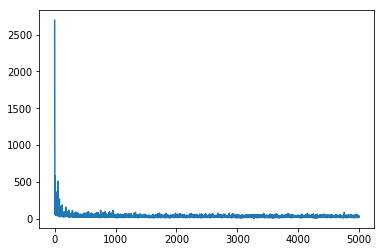

In [18]:
plt.figure()
plt.plot(losses)
plt.show()

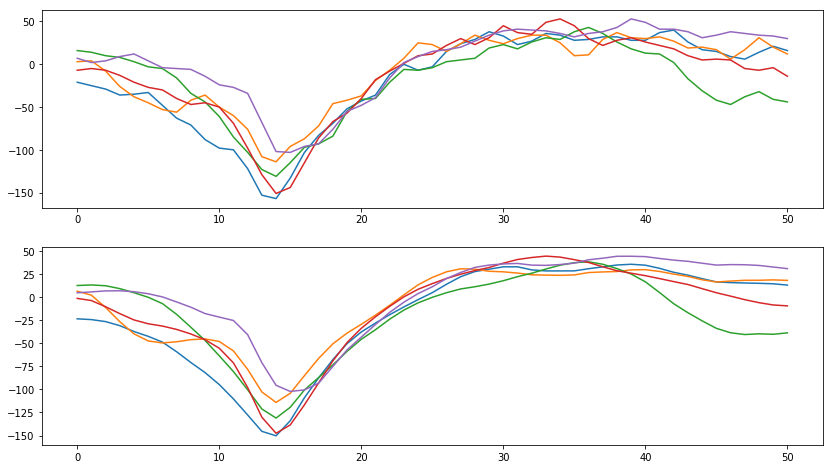

In [21]:
plt.figure(figsize=(14,8))

# n = [1, 30, 45, 50, 65]
n = [3490, 1098, 2377, 9, 871]


for i in n:
    data = electrode_data_test[i, :]
    data = torch.from_numpy(data).float().cuda()
    enc, o = ae_1.forward(data)
    o = (o.data).cpu().numpy()
    plt.subplot(211)
    plt.plot(electrode_data_test[i, :])
    plt.subplot(212)
    plt.plot(o)
plt.show()

## Using GANs for super-resolution

### Designing the GAN

In [22]:
class generator(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(generator, self).__init__()
        activation_layer = nn.PReLU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 100),
                                     activation_layer,
                                     nn.Linear(100, 50),
                                     activation_layer,
                                     nn.Linear(50, 25),
                                     activation_layer,
                                     nn.Linear(25, 80),
                                     activation_layer,
                                     nn.Linear(80, 28),
                                     activation_layer,
                                     nn.Linear(28, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 16),
                                     activation_layer,
                                     nn.Linear(16, 25),
                                     activation_layer,
                                     nn.Linear(25, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

In [23]:
class discriminator(nn.Module):
    def __init__(self, input_size):
        super(discriminator, self).__init__()
        self.detect = nn.Sequential(nn.Linear(input_size, 32),
                                    nn.ELU(),
                                    nn.Linear(32, 16),
                                    nn.ELU(),
                                    nn.Linear(16, 4),
                                    nn.ELU(),
                                    nn.Linear(4, 1),
                                    nn.Sigmoid())
    def forward(self, x):
        out = self.detect(x)
        return out

In [24]:
def train_gan(disc, gen, input_data, d_criterion, g_criterion, d_optimizer, g_optimizer, epoch_range,  
              batch_size_d, batch_size_g):
    for num_epoch in range(epoch_range):
        d_selected = random.sample(range(0, input_data.shape[0]), batch_size_d)

        for feats in d_selected:
            #---------Training the discriminator on real data------#
            real_data = input_data[feats, :]
            real_data = torch.from_numpy(real_data).float().cuda()
            #---------FORWARD------------#
            real_decision = disc.forward(real_data)
            real_decision = torch.tensor(real_decision).float().cuda()
            real_loss = d_criterion(real_decision, Variable(torch.ones(1)).cuda())
            #---------BACKWARD------------#
            real_loss.backward()
            
            #---------Training the discriminator on fake data------#
            enc, fake_data = gen.forward(real_data)
            fake_data = torch.tensor(fake_data).float().cuda()
            #---------FORWARD------------#
            fake_decision = disc.forward(fake_data)
            fake_decision = torch.tensor(fake_decision).float().cuda()
            fake_loss = d_criterion(fake_decision, Variable(torch.zeros(1)).cuda())
            #---------BACKWARD------------#
            fake_loss.backward()
            
            d_optimizer.zero_grad()            
            d_optimizer.step()
        
        g_selected = random.sample(range(0, input_data.shape[0]), batch_size_g)
        
        for feats in g_selected:
            x = input_data[feats, :]
            x = torch.from_numpy(x).float().cuda()
            #---------FORWARD------------#
            enc, out = gen.forward(x)
            out = torch.tensor(out).float().cuda()
            g_loss = g_criterion(out, x)
            #---------BACKWARD------------#
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
        print('epoch [{}/{}], disc_real_loss:{:.4f}, disc_fake_loss:{:.4f}, gen_loss:{:.4f}'.format(num_epoch + 1, 
                                                    epoch_range, real_loss.data[0], fake_loss.data[0], g_loss.data[0]))
    return out

In [25]:
def init_gan_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)

In [29]:
epoch_range = 100
batch_size_d = 150
batch_size_g = 100
g_learning_rate = 0.0001
d_learning_rate = 0.0001
embedding_size = 5

# Defining the models
gen = generator(length, embedding_size).cuda()
disc = discriminator(length).cuda()

# Initialising the weights
gen.apply(init_gan_weights)
disc.apply(init_gan_weights)

# Setting up the loss criteria
g_criterion = nn.MSELoss()
d_criterion = nn.BCELoss()

# Setting up the Optimizer (Using Adam here)
g_optimizer = torch.optim.Adam(
    gen.parameters(), lr=g_learning_rate, weight_decay=0.001)
d_optimizer = torch.optim.Adam(
    disc.parameters(), lr=d_learning_rate, weight_decay=0.001)

out = train_gan(disc, gen, electrode_data_train, d_criterion, g_criterion, 
                             d_optimizer, g_optimizer, epoch_range, batch_size_d, batch_size_g)

epoch [1/100], disc_real_loss:0.0000, disc_fake_loss:3.1525, gen_loss:608.2474
epoch [2/100], disc_real_loss:0.0000, disc_fake_loss:5.7508, gen_loss:1561.7115
epoch [3/100], disc_real_loss:0.0000, disc_fake_loss:7.7127, gen_loss:910.8860
epoch [4/100], disc_real_loss:0.0001, disc_fake_loss:7.2065, gen_loss:365.0729
epoch [5/100], disc_real_loss:0.0000, disc_fake_loss:6.4092, gen_loss:436.5251
epoch [6/100], disc_real_loss:0.0001, disc_fake_loss:7.3927, gen_loss:188.7073
epoch [7/100], disc_real_loss:0.0000, disc_fake_loss:8.3962, gen_loss:191.3923
epoch [8/100], disc_real_loss:0.3531, disc_fake_loss:2.9600, gen_loss:95.3162
epoch [9/100], disc_real_loss:0.1244, disc_fake_loss:2.8714, gen_loss:280.9564
epoch [10/100], disc_real_loss:0.0665, disc_fake_loss:2.3163, gen_loss:229.4408
epoch [11/100], disc_real_loss:0.1855, disc_fake_loss:2.2318, gen_loss:127.0646
epoch [12/100], disc_real_loss:0.1063, disc_fake_loss:1.2816, gen_loss:90.7216
epoch [13/100], disc_real_loss:0.2495, disc_fake_l

-7.899686098098755
11.870727896690369
-----------------
-8.460121497511864
17.5805441737175
-----------------
-10.951744556427002
42.27991342544556
-----------------
-3.1704137325286865
16.38005304336548
-----------------
-12.66503119468689
18.610430657863617
-----------------
-9.747145920991898
-22.238530680537224
-----------------
2.717270791530609
17.461711645126343
-----------------


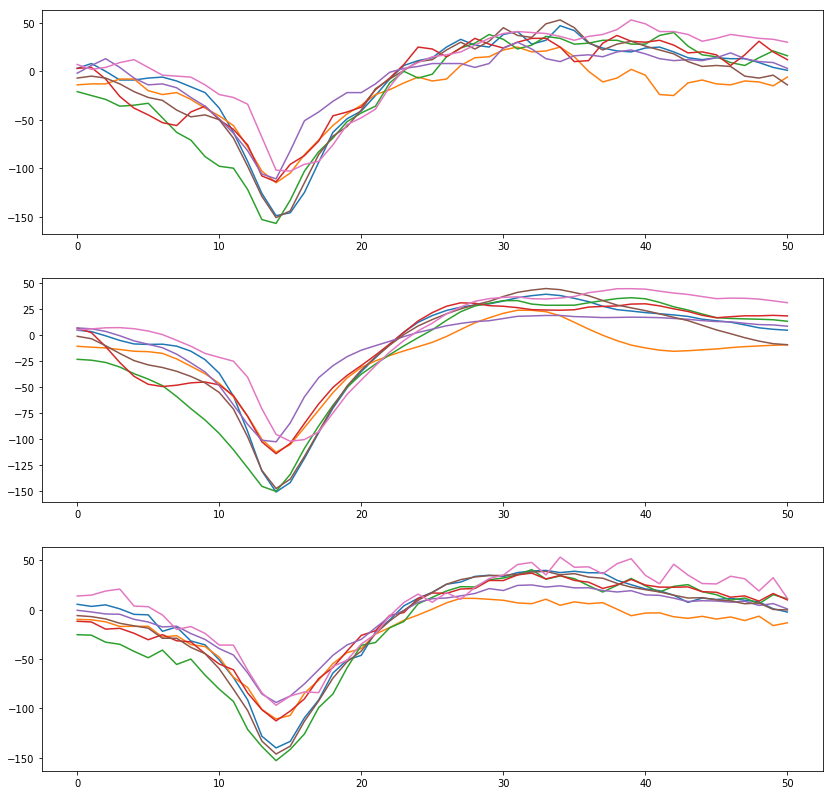

In [30]:
plt.figure(figsize=(14,14))

# n = [1, 30, 45, 50, 65]
n = [11, 290, 3490, 1098, 2707, 9, 871]


for i in n:
    data = electrode_data_test[i, :]
    data = torch.from_numpy(data).float().cuda()
    enc, o = ae_1.forward(data)
    o = (o.data).cpu().numpy()
    print(np.sum(np.subtract(electrode_data_test[i, :], o)))
    enc, o_gan = gen.forward(data)
    o_gan = (o_gan.data).cpu().numpy()
    print(np.sum(np.subtract(electrode_data_test[i, :], o_gan)))
    print('-----------------')
    plt.subplot(311)
    plt.plot(electrode_data_test[i, :])
    plt.subplot(312)
    plt.plot(o)
    plt.subplot(313)
    plt.plot(o_gan)
plt.show()

In [ ]:
#torch.save(model, 'autoencoder_26062018.pt') #Saving the autoencoder model

## Designing VAE for Test